In [196]:
## import libraries

import os
import math
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
from torch import optim
import plotly.graph_objects as go
from matplotlib import pyplot as plt

In [197]:
# Functions

def clean(row, frame):
    if row.name != 0:
        
        Today_Open = frame["Open"][row.name]
        Yest_High = frame["High"][row.name-1]
        Yest_Low = frame["Low"][row.name-1]
        Yest_Close = frame["Close"][row.name-1]
        Yest_Volume = frame["Volume"][row.name-1]
        
        Yest_Open = frame["Open"][row.name-1]
        Today_Close = frame["Close"][row.name]
        
        if Yest_Close - Yest_Open >= 0:
            Yest_Price_Change = 1
        else:
            Yest_Price_Change = 0
            
        if Today_Close - Today_Open >= 0:
            Today_Price_Change = 1
        else:
            Today_Price_Change = 0
                      
        return Today_Open, Yest_High, Yest_Low, Yest_Close, Yest_Volume, Yest_Price_Change, Today_Price_Change
  
def s_ized(col):
    if col.name == "Price_Change_Yest" or col.name == "Price_Change_Today":
        new = col
    else:
       mean = np.mean(col)
       std = np.std(col)
       new = np.nan_to_num((col - mean) / std)

    return new


def loss_f(y_pred, y):
    return sum(y*(y_pred**.5) + ((1-y) * (1-y_pred)**.5)) / len(y_pred)

In [198]:
all_Js = []
accuracys = []

for loop in range(25,76,25):
    # weights
    weights_1 = np.random.uniform(low=-0.0001, high=.0001, size=(6,3))
    weights_2 = np.random.uniform(low=-0.0001, high=.0001, size=(6,3))

    split_ratio = .70
    l_rate = .0001

    # Load and Clean the Data
    arr = os.listdir('sample set')
    all_data = pd.DataFrame() 
    #o=1
    for file in arr[:loop]:
        #print(o)
        #o += 1
        file2 = open("sample set/" + file)
        data = pd.read_csv(file2)
        new_df = data.apply(clean, axis=1, frame = data, result_type = "broadcast")
        new_df2 = new_df.drop([0])
        all_data = all_data.append(new_df2)

    all_data = all_data.rename(columns={'Date': 'Open', 'Open': 'High', 'High':'Low', 'Low':'Close','Close':'Volume','Volume':'Price_Change_Yest', 'OpenInt':'Price_Change_Today'})
    all_data = all_data.apply(s_ized, axis=0)

    # more cleaning
    array = all_data.values
    Xs= array[:,:6]
    Y = array[:,6]

    Xs = Xs.tolist()
    Y = Y.tolist()

    Xs = torch.tensor(Xs)
    y = torch.tensor(Y)

    y = y.reshape(Xs.shape[0],1)

    # Split Data
    train_num = int(Xs.shape[0] * split_ratio)
    train_Xs = Xs[:train_num]
    test_Xs = Xs[train_num:]
    train_y = y[:train_num]
    test_y = y[train_num:]

    # weights
    weights_1 = np.random.uniform(low=-1, high=1, size=(6,3))
    weights_2 = np.random.uniform(low=-1, high=1, size=(6,3))
    weights_3 = np.random.uniform(low=-1, high=1, size=(6,1))


# Auto Encode Trainer
    Js = []
    for i in range(30):
        # Encode
        # rowsx6 * 6x3
        output1 = train_Xs @ weights_1

        # Decode
        # rowsx3 * 3x6
        output2 = output1 @ weights_2.T

        # FC
        # rowsx6 * 6*1
        output3 = output2 @ weights_3

        # Logistic Activation 
        y_preds = 1 / (1 + math.e**(-output3))


        #Gradient of FC
        grad1 = (((train_y - y_preds)) * ((1 - y_preds) * y_preds)).T @ output2
        grad1 = grad1.T
        weights_3 = weights_3 - np.array(l_rate*(grad1))

        # Gradient of Decode 
        grad2 = (((train_y - y_preds) * ((1 - y_preds) * y_preds)) @ weights_3.T).T @ output1
        weights_2 = weights_2 - np.array(l_rate*(grad2))

        # Gradient of Encode
        grad3 = ((((train_y - y_preds) * ((1 - y_preds) * y_preds)) @ weights_3.T) @ weights_2).T @ train_Xs
        grad3 = grad3.T
        weights_1 = weights_1 - np.array(l_rate*(grad3))


        # Objective Func Loss
        loss = loss_f(y_preds, train_y)
        t_loss = sum(loss).item()
        Js.append(t_loss)
    
# Test Accuracy

    # Encode
    # rowsx6 * 6x3
    output1 = test_Xs @ weights_1

    # Decode
    # rowsx3 * 3x6
    output2 = output1 @ weights_2.T

    # FC
    # rowsx6 * 6*1
    output3 = output2 @ weights_3

    # Logistic Activation 
    y_preds = 1 / (1 + math.e**(-output3))

    predictions = np.where(y_preds > .5, 1, 0)
    accuracy = list(predictions-np.array(test_y)).count(0) / len(predictions-np.array(test_y)) 
    

    all_Js.append(Js)
    accuracys.append(accuracy)

0.4788298012953254


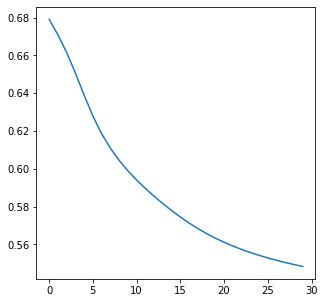

In [199]:
print(accuracy)
fig = plt.figure(figsize=(5,5))
graph = plt.plot(range(0,30), all_Js[0])

0.4788298012953254


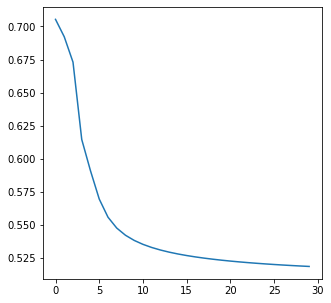

In [200]:
print(accuracy)
fig = plt.figure(figsize=(5,5))
graph = plt.plot(range(0,30), all_Js[1])

0.4788298012953254


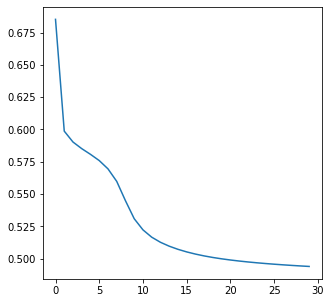

In [201]:
print(accuracy)
fig = plt.figure(figsize=(5,5))
graph = plt.plot(range(0,30), all_Js[2])